# Training Latent Graph Autoencoder

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import torchvision
import torch
from torchvision.transforms import Compose, ToTensor, Resize, Scale
from torch.utils.data.dataloader import DataLoader
from graph_autoencoder import LatentGraphVAE
import matplotlib.pyplot as plt
import numpy as np

In [6]:
device = 'cuda:1'

In [7]:
transforms = Compose([
    ToTensor(),
    Resize((320//2, 480//2)),
    ])
dataset = torchvision.datasets.ImageFolder('data/CLEVR_v1.0/images/train', transform=transforms)
dataloader = DataLoader(dataset=dataset, batch_size=1)

In [30]:
def overlap_penalty(layers):
    nlayers = layers.shape[0]
    idxs = torch.combinations(torch.arange(nlayers)).to(device)
    min = torch.min(layers)
    max = torch.max(layers)
    rng = (max-min)**2
    rng = rng.detach()
    overlap = (rng - torch.mean((layers[idxs[:,0]] - layers[idxs[:,1]])**2))/rng
    return overlap

In [49]:
lgvae = LatentGraphVAE(n_channels=3, w=320//2, h=480//2, device=device).to(device)
optim = torch.optim.Adam(params=lgvae.parameters())

optim.zero_grad()
batch_size = 100
n_epochs = 1
i=0
batch_loss = 0
batch_overlap = 0
checkpoint = 1000

tmstp = '20221201_1342'

image,_ = next(iter(dataloader))
print(image.shape)

for epoch in range(n_epochs):
    i=0
    # for image,_ in dataloader:
    for j in range(100000):
        image = image.squeeze(0).to(device)
        nodes = lgvae(image)
        recon = nodes.sum(dim=0)
        overlap = overlap_penalty(nodes)
        recon_loss = torch.mean((recon - image)**2) 
        loss = recon_loss + overlap
        loss.backward()
        batch_loss += float(loss)/batch_size
        batch_overlap += float(overlap)/batch_size
        
        i+=1
        if i%batch_size==0:
            optim.step()
            optim.zero_grad()
            print(f"epoch={epoch:4d} n={i:8d} loss={batch_loss:8.4f} overlap={batch_overlap:8.4f}", flush=True)
            batch_loss = 0
            batch_overlap = 0
        if i%checkpoint==0:
            torch.save(lgvae.state_dict(), f'models/lgvae_{tmstp}.torch')

torch.Size([1, 3, 160, 240])
epoch=   0 n=     100 loss=  2.8558 overlap=  1.0000
epoch=   0 n=     200 loss=  2.8085 overlap=  1.0000
epoch=   0 n=     300 loss=  2.7851 overlap=  1.0000
epoch=   0 n=     400 loss=  2.7687 overlap=  1.0000
epoch=   0 n=     500 loss=  2.7534 overlap=  1.0000
epoch=   0 n=     600 loss=  2.7383 overlap=  1.0000
epoch=   0 n=     700 loss=  2.7231 overlap=  1.0000
epoch=   0 n=     800 loss=  2.7073 overlap=  1.0000
epoch=   0 n=     900 loss=  2.6898 overlap=  1.0000
epoch=   0 n=    1000 loss=  2.6651 overlap=  1.0000
epoch=   0 n=    1100 loss=  2.6182 overlap=  1.0000
epoch=   0 n=    1200 loss=  2.5138 overlap=  1.0000
epoch=   0 n=    1300 loss=  2.3091 overlap=  1.0000
epoch=   0 n=    1400 loss=  2.0428 overlap=  1.0000
epoch=   0 n=    1500 loss=  2.0797 overlap=  1.0000
epoch=   0 n=    1600 loss=  1.8234 overlap=  1.0000
epoch=   0 n=    1700 loss=  1.7398 overlap=  1.0000
epoch=   0 n=    1800 loss=  1.6541 overlap=  1.0000
epoch=   0 n=    

KeyboardInterrupt: 

In [12]:
def to_np(tnsr):
    return tnsr.detach().cpu().numpy().transpose((1,2,0))

In [15]:
val_dataset = torchvision.datasets.ImageFolder('data/CLEVR_v1.0/images/train', transform=transforms)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
iter_val_loader = iter(val_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


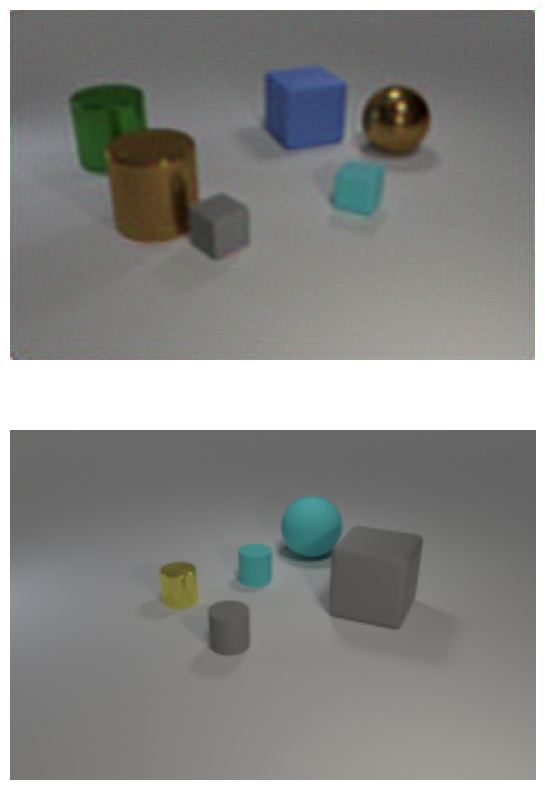

In [16]:
fig, axs = plt.subplots(2,1, figsize=(10,10))

with torch.no_grad():
    val_recons = []
    for i in range(10):
        val_image,_ = next(iter_val_loader)
        val_image = val_image.squeeze(0).to(device)
        val_nodes = lgvae(val_image)
        val_recon = val_nodes.sum(dim=0)
        val_nprecon = to_np(val_recon)
        val_recons.append(val_recon)
    # print((val_recons[8] - vala_recons[2]).sum())
    axs[0].axis('off')
    axs[0].imshow(val_nprecon)
    axs[1].axis('off')
    axs[1].imshow(to_np(val_image))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


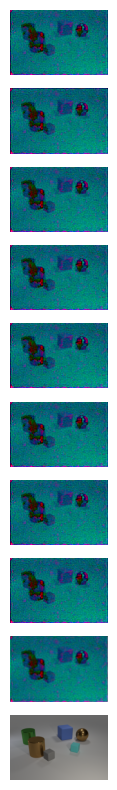

In [50]:
n_nodes = nodes.shape[0]
fig, axs = plt.subplots(n_nodes+2, figsize=(40,10))
for i in range(n_nodes):
    node_np = to_np(nodes[i])
    axs[i].axis('off')
    axs[i].imshow(node_np*8, interpolation='none')
axs[n_nodes].axis('off')
axs[n_nodes].imshow(to_np(recon))
axs[n_nodes+1].axis('off')
axs[n_nodes+1].imshow(to_np(image))

In [46]:
nodes[:,2,:4,:4]

tensor([[[4.2921e-01, 4.2885e-01, 4.2860e-01, 4.2853e-01],
         [4.2943e-01, 4.2957e-01, 4.2952e-01, 4.2982e-01],
         [4.2927e-01, 4.2967e-01, 4.2967e-01, 4.2981e-01],
         [4.2889e-01, 4.2936e-01, 4.2928e-01, 4.2929e-01]],

        [[4.2965e-01, 4.2953e-01, 4.2956e-01, 4.2938e-01],
         [4.2963e-01, 4.2964e-01, 4.2946e-01, 4.2942e-01],
         [4.2959e-01, 4.2955e-01, 4.2938e-01, 4.2968e-01],
         [4.2959e-01, 4.2958e-01, 4.2944e-01, 4.2960e-01]],

        [[4.2112e-08, 7.8729e-16, 1.2448e-20, 3.9230e-22],
         [1.7820e-14, 5.2407e-24, 5.4767e-30, 6.3606e-32],
         [1.7005e-18, 3.1007e-29, 3.6593e-36, 1.4799e-38],
         [5.9503e-20, 3.1535e-31, 1.3132e-38, 0.0000e+00]],

        [[3.3251e-17, 1.1419e-34, 0.0000e+00, 0.0000e+00],
         [1.2730e-31, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[2.4686e-19, 4.4695e-39, 0.0000e+00, 0.